# Random basics - datasets / dataloaders & optimizers 

Things in this notebook:
- simple regression problem
- data management from scratch
- optimizers from scratch incl. monitoring & hyper parameter schedulers

In this notebook I experiment with creating a custom dataset and transform as well as with creating some optimizers from scratch using pytorch. My personal highlight was to see that even a method like Covariance Matrix Adaption (an evolutionary strategy based algorithm) can be implemented using pytorch and actually performs reasonably well.

A bit surprising, and I suspect a bug is, is that the default SGD optimizer from pytorch performs quite poorly in comparison.

**Things to look at**

1. DONE opt: SGD, RMSProp, Adam, evo ([example](https://towardsdatascience.com/paper-repro-deep-neuroevolution-756871e00a66))
2. nets: dense, conv, recurrent, ResNet, DensNet
3. regularization: dropout, l2, weight decay, batchnorm
4. DONE data bunching (this kind of seems nasty) - data/application: image, tabular, sequence/text, collab
5. GANs, U-net, Feature loss

**TO DO: check why converged solutions look so bad**

**TO DO: refactor optimizers using inheritance from a generic optimizer class (see lecture 11)**

**TO DO: cyclical learning rates: [Smith et al. 2017](https://arxiv.org/abs/1506.01186), [Smith and Topin 2018](https://arxiv.org/pdf/1708.07120.pdf), [medium blog](https://medium.com/dsnet/the-1-cycle-policy-an-experiment-that-vanished-the-struggle-in-training-neural-nets-184417de23b9) post by Shubhaajit Das, [Smith 2018](http://arxiv.org/abs/1803.09820)**

**TO DO: callbacks --> new version of this notebook using callbacks (add progressbar from fastprogress module)**

In [1]:
%matplotlib inline

In [2]:
from fastai.data_block import ItemList, ItemBase
from fastai import basic_data
from fastai.basic_data import DataBunch
from fastai.tabular import TabularList, Normalize, FillMissing

In [127]:
from fastai.basics import torch

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Union
from functools import partial

import bokeh.io as bokeh_io
import bokeh.plotting as bokeh_plotting
import bokeh.models as bokeh_models
import bokeh.palettes as bokeh_palettes

In [3]:
bokeh_io.output_notebook()

Loading BokehJS ...

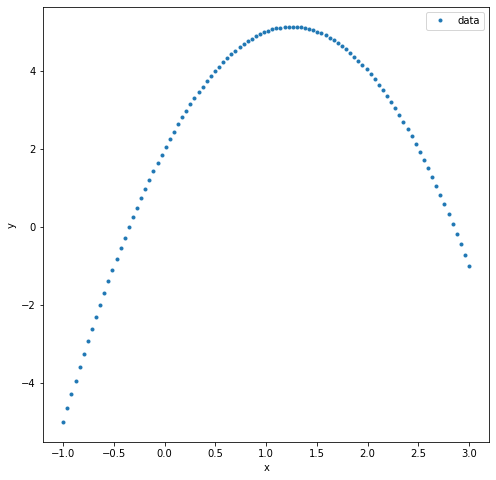

In [4]:
def polynomify(x: torch.Tensor, deg: int):
    X = torch.empty(len(x), deg)
    for i in range(deg):
        X[:,i] = x ** (deg-i-1)
    return X

n_obs = 100
x = torch.linspace(-1, 3, n_obs)
# w = torch.tensor([2., 1., 10.])
w = torch.tensor([-2, 5, 2.])
deg = len(w)
X = polynomify(x, deg)
y_err = stats.norm(loc=0, scale=.1).rvs(size=x.shape[0])
y_err = torch.from_numpy(y_err)
y_fun = lambda x: x@w# + y_err

y = y_fun(X)
figsize = (8,8)
fig, ax = plt.subplots(figsize=figsize)
ax.plot(x, y, ".", label="data")
ax.set_xlabel("x")
ax.set_ylabel("y")
# ax.set_aspect("equal")
ax.legend()
plt.show()

In [5]:
x, y, X

(tensor([-1.0000, -0.9596, -0.9192, -0.8788, -0.8384, -0.7980, -0.7576, -0.7172,
         -0.6768, -0.6364, -0.5960, -0.5556, -0.5152, -0.4747, -0.4343, -0.3939,
         -0.3535, -0.3131, -0.2727, -0.2323, -0.1919, -0.1515, -0.1111, -0.0707,
         -0.0303,  0.0101,  0.0505,  0.0909,  0.1313,  0.1717,  0.2121,  0.2525,
          0.2929,  0.3333,  0.3737,  0.4141,  0.4545,  0.4949,  0.5354,  0.5758,
          0.6162,  0.6566,  0.6970,  0.7374,  0.7778,  0.8182,  0.8586,  0.8990,
          0.9394,  0.9798,  1.0202,  1.0606,  1.1010,  1.1414,  1.1818,  1.2222,
          1.2626,  1.3030,  1.3434,  1.3838,  1.4242,  1.4646,  1.5051,  1.5455,
          1.5859,  1.6263,  1.6667,  1.7071,  1.7475,  1.7879,  1.8283,  1.8687,
          1.9091,  1.9495,  1.9899,  2.0303,  2.0707,  2.1111,  2.1515,  2.1919,
          2.2323,  2.2727,  2.3131,  2.3535,  2.3939,  2.4343,  2.4747,  2.5152,
          2.5556,  2.5960,  2.6364,  2.6768,  2.7172,  2.7576,  2.7980,  2.8384,
          2.8788,  2.9192,  

In [6]:
def MSELoss(pred, truth):
    Δ = pred - truth
    Δ2 = Δ * Δ
    return Δ2.mean()

In [7]:
MSELoss(X@w, y)

tensor(0.)

In [8]:
def get_split_indices(n: int, val_pct: float = .2):
    val_pct = .2
    n_val = int(n*val_pct)
    ix = torch.randperm(n) 
    return ix[n_val:], ix[:n_val]

ix_train, ix_val = get_split_indices(n_obs, val_pct=.2)
print(ix_train.size(), ix_val.size())

torch.Size([80]) torch.Size([20])


## Custom data set and data loader

In [9]:
class XYDataset:
    "Basic data storage"
    def __init__(self, x: torch.tensor, y: torch.tensor):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    

def noisify(xy, device="cpu", std_x=.1, std_y=.1):
    x, y = xy
    if not torch.is_tensor(x):
        x = torch.from_numpy(x).clone().to(device)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y).clone().to(device)
    
    
    dx = torch.normal(mean=0., std=std_x, size=x.size()).to(device)
    dy = torch.normal(mean=0., std=std_x, size=y.size()).to(device)
    return x + dx, y + dy


def random_order(end, bs):
    ix = torch.randperm(end)
    for i in range(0, end, bs):
        yield ix[i:i+bs]
        
def boring_order(end, bs):
    ix = torch.arange(end)
    for i in range(0, end, bs):
        yield ix[i:i+bs]
        
    
class XYDataLoader:
    "Provides an iterator (plus sampler) and transforms over stored data"
    def __init__(self, ds: XYDataset, bs: int = 1, sampler_callback: callable = None, trafos: List[callable]=None):
        self.ds = ds
        self.bs = bs
        self.sampler = sampler_callback if sampler_callback is not None else boring_order
        self.trafos = trafos
        
    def transform_batch(self, batch):
        if self.trafos is not None:
            for trafo in self.trafos:
                batch = trafo(batch)
        return batch
        
    def __iter__(self):
        for s in self.sampler(len(self.ds), self.bs):
            yield self.transform_batch(self.ds[s])


class XYDatabunch:
    "Bunches different data loaders"
    g: dict = {"train": None, "valid": None}
    
    def __init__(self, dl_train: XYDataLoader, dl_valid: XYDataLoader):
        self.dl_train = dl_train
        self.dl_valid = dl_valid
        
    def one_batch(self):
        return self.get_data(kind="train")
    
    def get_data(self, kind: str = "train", flag_end=False):
        assert kind in self.g
        get_iterator = lambda x: iter(getattr(self, f"dl_{x}"))
        if self.g[kind] is None: 
            self.g[kind] = get_iterator(kind)
        try:
            if flag_end:
                return next(self.g[kind]), False
            return next(self.g[kind])
        except StopIteration:
            print(f"Reached the limit of the {kind} data set, restarting.")
            self.g[kind] = get_iterator(kind)
            if flag_end:
                return next(self.g[kind]), True
            return next(self.g[kind])
            

bs_train, bs_valid = 20, 10
ds_train = XYDataset(X[ix_train], y[ix_train])
ds_valid = XYDataset(X[ix_val], y[ix_val])
dl_train = XYDataLoader(ds_train, bs=bs_train, sampler_callback=random_order, # random_order boring_order
                        trafos=None)  # [partial(noisify, std_x=.001)]
dl_valid = XYDataLoader(ds_valid, bs=bs_valid, sampler_callback=random_order, 
                        trafos=None)  # [partial(noisify, std_x=.001)]
db = XYDatabunch(dl_train, dl_valid)

In [10]:
print(db.get_data("train", flag_end=True))

((tensor([[ 1.3967,  1.1818,  1.0000],
        [ 8.2874,  2.8788,  1.0000],
        [ 5.3506,  2.3131,  1.0000],
        [ 2.1452,  1.4646,  1.0000],
        [ 0.0123, -0.1111,  1.0000],
        [ 0.0981, -0.3131,  1.0000],
        [ 0.1887, -0.4343,  1.0000],
        [ 1.9150,  1.3838,  1.0000],
        [ 0.3552, -0.5960,  1.0000],
        [ 1.4938,  1.2222,  1.0000],
        [ 2.3884,  1.5455,  1.0000],
        [ 0.2254, -0.4747,  1.0000],
        [ 0.6368, -0.7980,  1.0000],
        [ 7.6042,  2.7576,  1.0000],
        [ 0.0230, -0.1515,  1.0000],
        [ 4.9833,  2.2323,  1.0000],
        [ 1.8048,  1.3434,  1.0000],
        [ 1.1249,  1.0606,  1.0000],
        [ 0.6694,  0.8182,  1.0000],
        [ 6.9504,  2.6364,  1.0000]]), tensor([ 5.1157, -0.1809,  2.8645,  5.0329,  1.4198,  0.2382, -0.5490,  5.0892,
        -1.6901,  5.1235,  4.9504, -0.8245, -3.2634,  0.5794,  1.1965,  3.1951,
         5.1075,  5.0533,  4.7521,  1.2810])), False)


In [11]:
db.one_batch()

(tensor([[ 1.7151e-01,  4.1414e-01,  1.0000e+00],
         [ 8.8246e-01,  9.3939e-01,  1.0000e+00],
         [ 4.8045e+00,  2.1919e+00,  1.0000e+00],
         [ 4.1221e+00,  2.0303e+00,  1.0000e+00],
         [ 2.9487e-02,  1.7172e-01,  1.0000e+00],
         [ 4.8577e-01,  6.9697e-01,  1.0000e+00],
         [ 1.0203e-04,  1.0101e-02,  1.0000e+00],
         [ 9.0000e+00,  3.0000e+00,  1.0000e+00],
         [ 3.6833e-02, -1.9192e-01,  1.0000e+00],
         [ 5.7309e+00,  2.3939e+00,  1.0000e+00],
         [ 1.2499e-01, -3.5354e-01,  1.0000e+00],
         [ 7.1651e+00,  2.6768e+00,  1.0000e+00],
         [ 8.4491e-01, -9.1919e-01,  1.0000e+00],
         [ 7.3830e+00,  2.7172e+00,  1.0000e+00],
         [ 4.4995e-02,  2.1212e-01,  1.0000e+00],
         [ 8.5808e-02,  2.9293e-01,  1.0000e+00],
         [ 1.1111e-01,  3.3333e-01,  1.0000e+00],
         [ 3.6446e+00,  1.9091e+00,  1.0000e+00],
         [ 2.6447e+00,  1.6263e+00,  1.0000e+00],
         [ 6.3260e+00,  2.5152e+00,  1.0000e+00]])

In [12]:
print(db.get_data("valid"))

(tensor([[ 0.4311,  0.6566,  1.0000],
        [ 2.9141,  1.7071,  1.0000],
        [ 2.2652,  1.5051,  1.0000],
        [ 3.9597,  1.9899,  1.0000],
        [ 0.3315,  0.5758,  1.0000],
        [ 5.9260,  2.4343,  1.0000],
        [ 8.0564,  2.8384,  1.0000],
        [ 0.7723, -0.8788,  1.0000],
        [ 0.7029, -0.8384,  1.0000],
        [ 0.4580, -0.6768,  1.0000]]), tensor([ 4.4207,  4.7072,  4.9949,  4.0301,  4.2158,  2.3197,  0.0791, -3.9385,
        -3.5977, -2.2999]))


Reached the limit of the train data set, restarting.
Reached the limit of the valid data set, restarting.
Reached the limit of the valid data set, restarting.


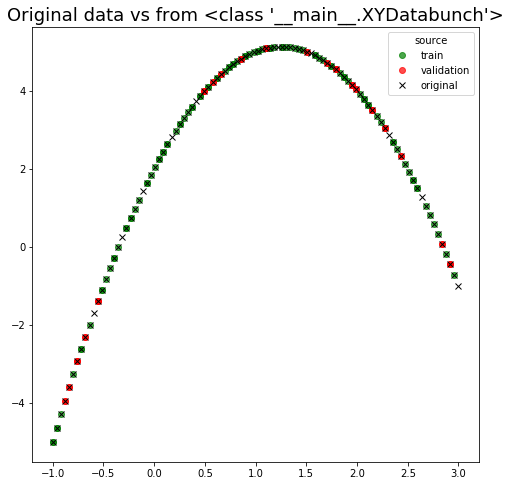

In [13]:
fig, ax = plt.subplots(figsize=figsize)
for _ in range(5):
    _x, _y = db.get_data("train")
    h_train, = ax.plot(_x[:, -2], _y, "go", label="train", alpha=.7)
for _ in range(5):
    _x, _y = db.get_data("valid")
    h_valid, = ax.plot(_x[:, -2], _y, "ro", label="validation", alpha=.7)
    
h_ori, = ax.plot(x, y, "kx", label="original")
ax.set_title(f"Original data vs from {db.__class__}", fontsize=18)
ax.legend(handles=[h_train, h_valid, h_ori], title="source")
plt.show()

In [14]:
class LinearModel:
    
    def __init__(self, w: torch.Tensor=None, deg: int = None):
        assert w is not None or deg is not None
        self.w = torch.nn.Parameter(torch.randn(deg)) if w is None else torch.nn.Parameter(w)
        self.lin = lambda X: X @ self.w
        
    def __call__(self, x):
        return self.forward(x)
            
    def forward(self, x):
        return self.lin(x)

In [15]:
lm_ori = LinearModel(w=w)
lm_ori(db.get_data("train")[0])

tensor([ 4.7778,  1.8466,  5.1235, -1.6901,  4.4562,  3.7277,  2.7996, -1.0000,
         5.0643,  2.8645,  0.2382,  0.3325, -1.9917,  1.4198,  4.9504,  5.1194,
         4.9790,  2.1250,  1.2810, -0.7204], grad_fn=<MvBackward>)

In [16]:
MSELoss(lm_ori(X), y)

tensor(0., grad_fn=<MeanBackward0>)

In [171]:
class Optimizer:
    
    name: str = None
    hyper_params: dict = None
    model_params = None
    
    def __init__(self, model_params, name="optimizer", **hyper_params):
        self.name = name
        self.hyper_params = hyper_params
        self.model_params = model_params
        
    def update(self):
        pass
    
    def zero_grad(self):
        self.model_params.grad.zero_()
    
    def __getattr__(self, k):
        return self.hyper_params[k]


class Telemetry:
    loss: dict = None
    weights: list = None
    hyper_params: dict = None
    x: list = None
    y: list = None
    y_pred: list = None
        
    def __repr__(self):
        return f"Telemetry\n{9*'='}\n"\
               f"loss: {self.loss}\n"\
               f"weights: {self.weights}\n"\
               f"hyper_params: {self.hyper_params}\n"\
               f"x: {self.x}\n"\
               f"y: {self.y}\n"\
               f"y_pred: {self.y_pred}\n"
        
    
class Recorder:
    "Collects data while training"
    stats: Telemetry = None 
        
    def __init__(self, stats: Telemetry = None):
        if stats is None:
            stats = Telemetry()
        self.stats = stats
    
    def store_loss(self, kind, val):
        v = val.clone().detach().item() if isinstance(val, torch.Tensor) else val
        
        if self.stats.loss is None:
            self.stats.loss = {kind: [v]}
        elif kind not in self.stats.loss:
            self.stats.loss[kind] = [v]
        else:
            self.stats.loss[kind].append(v)
    
    def store_hyper_params(self, opt: Optimizer):
        if self.stats.hyper_params is None:
            self.stats.hyper_params = {}
            for key, val in opt.hyper_params.items():
                self.stats.hyper_params[key] = [val]
        else:
            for key, val in opt.hyper_params.items():
                self.stats.hyper_params[key].append(val)
                
    def store_weights(self, model_params):
        if self.stats.weights is None:
            self.stats.weights = []
        self.stats.weights.append(model_params.clone().detach())
        
    def store_batch(self, _x: torch.Tensor, _y: torch.Tensor, y_pred: torch.Tensor):
        if self.stats.x is None:
            self.stats.x = []
        if self.stats.y is None:
            self.stats.y = []
        if self.stats.y_pred is None:
            self.stats.y_pred = []
        
        self.stats.x.append(_x.clone().detach())
        self.stats.y.append(_y.clone().detach())
        self.stats.y_pred.append(y_pred.clone().detach())
        
        
class Plotter:
    
    stats : Telemetry = None
        
    def __init__(self, rec: Recorder = None, stats: Telemetry = None):
        assert (rec is not None) != (stats is not None)
        self.stats = rec.stats if rec is not None else stats
    
    def plot_loss(self):
        
        iters = np.arange(len(self.stats.loss["train"]))
        s = bokeh_plotting.ColumnDataSource({"Iteration": iters, 
                                             "Train": self.stats.loss["train"],
                                             "Validation": self.stats.loss["valid"]})
        colors = bokeh_palettes.Inferno3
        
        fig = bokeh_plotting.figure(plot_width=700, plot_height=400, title="Losses vs iteration")
        label = "Train"
        fig.line(x="Iteration", y="Train", source=s, legend_label=label, color=colors[0],
                 line_width=2)
        # fig.circle(x="Iteration", y="TrainLoss", source=s, size=10, legend_label=label, color=colors[0])
        label = "Validate"
        fig.line(x="Iteration", y="Validation", source=s, legend_label=label, color=colors[1],
                 line_width=2)
        # fig.circle(x="Iteration", y="ValLoss", source=s, size=10, legend_label=label, color=colors[1])
        hover = bokeh_models.HoverTool(
            tooltips = [
                ("Iteration", "@Iteration"),
                ("Train", "@Train"),
                ("Validation", "@Validation"),
            ],
            formatters = {"Iteration": "numeral", "Train": "numeral", "Validation": "numeral"},
            mode="vline"
        )
        fig.xaxis.axis_label = "Iteration"
        fig.yaxis.axis_label = "Loss"
        fig.tools.append(hover)
        bokeh_plotting.show(fig)
        
    def plot_weights(self):
        
        iters = np.arange(len(self.stats.loss["train"]))
        w = np.array([_w.clone().detach().numpy() for _w in self.stats.weights])
        colors = bokeh_palettes.Inferno3
        
        _s = {"Iteration": iters}
        for i, _w in enumerate(w.T):
            _s[f"w_{i}"] = _w
        s = bokeh_plotting.ColumnDataSource(_s)
        
        fig = bokeh_plotting.figure(plot_width=700, plot_height=400, title="Model weights vs iteration")
        for i in range(w.shape[1]):
            label = f"w_{i}"
            fig.line(x="Iteration", y=label, source=s, legend_label=label, color=colors[i], line_width=2)
            # fig.circle(x="Iteration", y=label, source=s, size=10, legend_label=label, color=colors[i])
            
        tooltips = [
                ("Iteration", "@Iteration"),
            ] + [(v, f"@{v}") for v in _s if v.startswith("w")]
        hover = bokeh_models.HoverTool(
            tooltips = tooltips,
            formatters = {k[0]: "numeral" for k in tooltips},
            mode="vline"
        )
        fig.tools.append(hover)
        bokeh_plotting.show(fig)
        
                
    def plot_hyper_params(self):
        
        iters = np.arange(len(self.stats.loss["train"]))
        colors = bokeh_palettes.Inferno256
        
        for hyper in sorted(self.stats.hyper_params):
            s = bokeh_plotting.ColumnDataSource({"Iteration": iters, hyper: self.stats.hyper_params[hyper]})
        
            fig = bokeh_plotting.figure(plot_width=700, plot_height=400, 
                                        title=f"Hyper parameters ('{hyper}') vs iteration")
            
            fig.line(x="Iteration", y=hyper, source=s, legend_label=hyper, line_width=2)
            # fig.circle(x="Iteration", y=hyper, source=s, size=10, legend_label=hyper)

            tooltips = [
                ("Iteration", "@Iteration"),                    
                (hyper, f"@{hyper}")
            ]
            
            hover = bokeh_models.HoverTool(
                tooltips = tooltips,
                formatters = {k[0]: "numeral" for k in tooltips},
                mode="mouse"
            )
            fig.tools.append(hover)
            bokeh_plotting.show(fig)

Sanity checking the recorder

In [98]:
del rec, opt

In [188]:
rec = Recorder()

n_epochs = 5
opt = Optimizer(None, lr=.1)
print("total epochs", n_epochs)
for epoch in range(n_epochs):
    print(f"\nepoch {epoch}")
    rec.store_loss("train", 42)
    rec.store_loss("valid", 82.)
    
    print("\tlr", opt.lr * .9)
    opt.lr *= .9
    rec.store_hyper_params(opt)
    rec.store_weights(torch.Tensor([1., 2., 3.]))
    _x, _y = db.get_data("train")
    with torch.no_grad():
        y_pred = _y + .1
    rec.store_batch(_x, _y, y_pred)

total epochs 5

epoch 0
	lr 0.09000000000000001

epoch 1
	lr 0.08100000000000002

epoch 2
	lr 0.07290000000000002

epoch 3
	lr 0.06561000000000002
Reached the limit of the train data set, restarting.

epoch 4
	lr 0.05904900000000002


In [189]:
rec.stats

Telemetry
loss: {'train': [42, 42, 42, 42, 42], 'valid': [82.0, 82.0, 82.0, 82.0, 82.0]}
weights: [tensor([1., 2., 3.]), tensor([1., 2., 3.]), tensor([1., 2., 3.]), tensor([1., 2., 3.]), tensor([1., 2., 3.])]
hyper_params: {'lr': [0.1, 0.1, 0.1, 0.1, 0.1]}
x: [tensor([[ 0.5437,  0.7374,  1.0000],
        [ 0.0858,  0.2929,  1.0000],
        [ 0.1397,  0.3737,  1.0000],
        [ 0.0295,  0.1717,  1.0000],
        [ 0.3552, -0.5960,  1.0000],
        [ 3.4920,  1.8687,  1.0000],
        [ 0.9208, -0.9596,  1.0000],
        [ 1.1249,  1.0606,  1.0000],
        [ 1.3967,  1.1818,  1.0000],
        [ 8.2874,  2.8788,  1.0000],
        [ 0.1887, -0.4343,  1.0000],
        [ 0.1715,  0.4141,  1.0000],
        [ 7.8287,  2.7980,  1.0000],
        [ 0.2866,  0.5354,  1.0000],
        [ 2.6447,  1.6263,  1.0000],
        [ 0.3797,  0.6162,  1.0000],
        [ 4.4568,  2.1111,  1.0000],
        [ 0.8825,  0.9394,  1.0000],
        [ 0.0368, -0.1919,  1.0000],
        [ 4.2878,  2.0707,  1.0000]]

In [174]:
len(rec.stats.hyper_params["lr"]), len(rec.stats.loss["train"])

(5, 5)

In [175]:
pl = Plotter(rec=rec)
pl.plot_loss()
pl.plot_hyper_params()
pl.plot_weights()

In [176]:
class SGD(Optimizer):
    
    def __init__(self, model_params, lr: float = .01):
        super().__init__(model_params, name="SGD", lr=lr)
        
    def update(self):
        
        with torch.no_grad():
            self.model_params.sub_(self.model_params.grad * self.lr)
        
            self.zero_grad()
            
class PyTorchOpt(Optimizer):
        
    def __init__(self, model_params, opt: torch.optim.Optimizer, **hyper_params):
        super().__init__(model_params, name="pytorch optimizer", **hyper_params)
        self.opt = opt([model_params], **hyper_params)
        
    def update(self):
        self.opt.step()
        self.opt.zero_grad()    

        
            
class HyperParamsScheduler:
    
    hyper_params: dict = None
    schedule_params: dict = None
        
    def __init__(self, opt: Optimizer, **schedule_params):
        self.hyper_params = opt.hyper_params
        self.schedule_params = schedule_params
        
    def __getattr__(self, k):
        return self.schedule_params[k]
    
    def update(self, epoch):
        pass

            
class LRDecayScheduler(HyperParamsScheduler):
        
    def __init__(self, opt: Optimizer, _lambda: float = .9):
        super().__init__(opt, _lambda=_lambda)
        
    def update(self, epoch):
        self.hyper_params["lr"] = self.hyper_params["lr"] * self._lambda
        

class Learner:
    "Manages the training"
    
    model = None  # model
    db = None  # data bunch
    opt = None  # optimizer
    rec = None  # recorder
    loss_fun = None
    hs = None  # hyper parameter scheduler
    epoch = 0
    
    def __init__(self, model, db: XYDatabunch, opt: Optimizer, loss_fun: MSELoss, rec: Recorder = None,
                 hyper_scheduler: HyperParamsScheduler=None):
        self.model = model
        self.db = db
        self.opt = opt
        self.loss_fun = loss_fun
        self.rec = rec if rec is not None else Recorder()
        self.hs = hyper_scheduler if hyper_scheduler is not None else HyperParamsScheduler(opt)
                
    def do_epoch(self):
                
        # train
        end_epoch = False
        while not end_epoch:
            (_x, _y), end_epoch = self.db.get_data("train", flag_end=True)
            _y_pred = self.model(_x)
            loss = self.loss_fun(_y_pred, _y)
            self.rec.store_loss("train", loss)
            loss.backward()
            self.hs.update(self.epoch)
            self.opt.update()
            self.rec.store_weights(self.opt.model_params)
            self.rec.store_batch(_x, _y, _y_pred)

            # validate
            with torch.no_grad():
                _x, _y = self.db.get_data("valid")
                _y_pred = self.model(_x)
                loss = self.loss_fun(_y_pred, _y)
                self.rec.store_loss("valid", loss)

            self.rec.store_hyper_params(opt)
    
        self.epoch += 1
        
    def fit(self, epochs: int=1):
        for epoch in range(epochs):
            self.do_epoch(epoch)

In [177]:
lm = LinearModel(deg=len(w))
# opt = SGD(lm.w, lr=.1)
opt = PyTorchOpt(lm.w, opt=torch.optim.SGD, lr=.01)
lrs = None # LRDecayScheduler(opt, _lambda=.9) 
learn = Learner(lm, db, opt, MSELoss, hyper_scheduler=lrs)

In [178]:
opt.model_params, learn.epoch

(Parameter containing:
 tensor([ 0.0774, -0.5694,  1.1844], requires_grad=True), 0)

In [179]:
learn.do_epoch()

Reached the limit of the valid data set, restarting.
Reached the limit of the train data set, restarting.
Reached the limit of the valid data set, restarting.


In [77]:
learn.fit(epochs=10)

Reached the limit of the train data set, restarting.
Reached the limit of the valid data set, restarting.
Reached the limit of the valid data set, restarting.
Reached the limit of the train data set, restarting.
Reached the limit of the valid data set, restarting.
Reached the limit of the valid data set, restarting.
Reached the limit of the train data set, restarting.
Reached the limit of the valid data set, restarting.
Reached the limit of the valid data set, restarting.
Reached the limit of the train data set, restarting.
Reached the limit of the valid data set, restarting.
Reached the limit of the valid data set, restarting.
Reached the limit of the train data set, restarting.
Reached the limit of the valid data set, restarting.
Reached the limit of the valid data set, restarting.
Reached the limit of the train data set, restarting.
Reached the limit of the valid data set, restarting.
Reached the limit of the valid data set, restarting.
Reached the limit of the train data set, resta

In [180]:
lm.w, learn.epoch

(Parameter containing:
 tensor([ 0.2613, -0.3679,  1.2618], requires_grad=True), 1)

In [183]:
learn.rec.stats

Telemetry
loss: {'train': [10.48410415649414, 9.083724975585938, 7.030219078063965, 12.279211044311523], 'valid': [13.1488676071167, 11.878055572509766, 11.833963394165039, 14.231579780578613]}
weights: [tensor([ 0.1585, -0.5063,  1.2175]), tensor([ 0.2142, -0.4549,  1.2412]), tensor([ 0.2917, -0.4014,  1.2679]), tensor([ 0.2613, -0.3679,  1.2618])]
hyper_params: {'lr': [0.01, 0.01, 0.01, 0.01]}
x: [tensor([[ 0.0450,  0.2121,  1.0000],
        [ 5.7309,  2.3939,  1.0000],
        [ 0.1397,  0.3737,  1.0000],
        [ 1.9150,  1.3838,  1.0000],
        [ 7.3830,  2.7172,  1.0000],
        [ 1.4938,  1.2222,  1.0000],
        [ 2.3884,  1.5455,  1.0000],
        [ 1.0000, -1.0000,  1.0000],
        [ 0.0295,  0.1717,  1.0000],
        [ 0.4050, -0.6364,  1.0000],
        [ 2.5149,  1.5859,  1.0000],
        [ 6.3260,  2.5152,  1.0000],
        [ 5.3506,  2.3131,  1.0000],
        [ 0.1715,  0.4141,  1.0000],
        [ 0.0230, -0.1515,  1.0000],
        [ 8.2874,  2.8788,  1.0000],
     

In [181]:
MSELoss(y, lm_ori(X))

tensor(0., grad_fn=<MeanBackward0>)

In [182]:
MSELoss(y, lm(X))

tensor(9.1302, grad_fn=<MeanBackward0>)

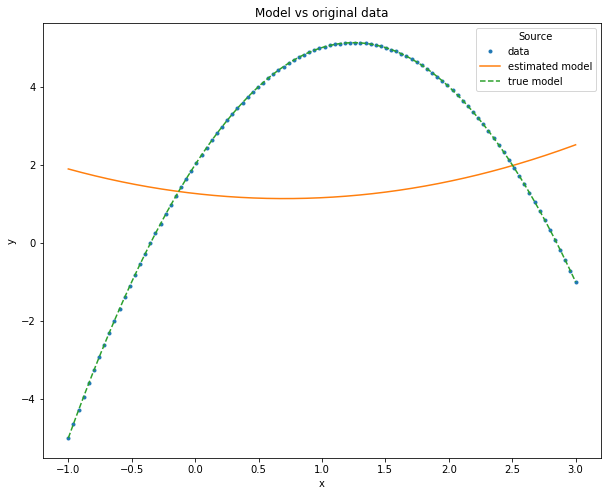

In [184]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x, y, ".", label="data")

with torch.no_grad():
    _x = torch.linspace(x.min(), x.max(), 1000)
    ax.plot(_x, lm(polynomify(_x, deg)), "-", label="estimated model")
    ax.plot(_x, lm_ori(polynomify(_x, deg)), "--", label="true model")
ax.legend(title="Source")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Model vs original data")
plt.show()

In [185]:
pl = Plotter(rec=learn.rec)
pl.plot_loss()

In [186]:
pl.plot_weights()

In [187]:
pl.plot_hyper_params()

## OLD

In [7]:
train_idx, valid_idx = get_train_valid_idx(x, y, val_pct=.8)
xy_train_ds = XYDataset(x[train_idx], y[train_idx])
xy_valid_ds = XYDataset(x[valid_idx], y[valid_idx])

In [8]:
xy_train_ds[2]

(tensor(2.6364, dtype=torch.float64), tensor(26.7277, dtype=torch.float64))

In [9]:
xy_valid_ds[4]

(tensor(0.0505, dtype=torch.float64), tensor(9.9704, dtype=torch.float64))

Creating a `DataBunch` version 1 via `torch.utils.data.DataLoader`

In [8]:
device = "cpu" # "cuda:0"

In [9]:
def noisify(xy):
    x, y = xy
    if not torch.is_tensor(x):
        x = torch.from_numpy(x).clone().to(device)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y).clone().to(device)
    
    dx = torch.normal(mean=0., std=.1, size=x.size()).to(device)
    dy = torch.normal(mean=0., std=.1, size=y.size()).to(device)
    return x + dx, y + dy

print(noisify((x[:5], y[:5])))

(tensor([-1.0347, -0.9406, -1.0914, -0.8036, -0.7749], dtype=torch.float64), tensor([11.0305, 10.8197, 10.9484, 10.5121, 10.6429], dtype=torch.float64))


In [10]:
bs = 10

In [11]:
xy_train_loader = torch.utils.data.DataLoader(xy_train_ds, batch_size=bs, shuffle=True)
xy_valid_loader = torch.utils.data.DataLoader(xy_valid_ds, batch_size=bs, shuffle=True)
xy_db = basic_data.DataBunch(train_dl=xy_train_loader, valid_dl=xy_valid_loader) #, dl_tfms=noisify)

In [12]:
class PolyModel(torch.nn.Module):
    
    def __init__(self, deg: int = 1):
        super().__init__()
        self.deg = deg
        self.w = torch.nn.Parameter(torch.randn(deg))
        
    def forward(self, x):
        if isinstance(x, list):
            x = x[1]
        n = len(x)
        X = torch.empty(n, self.deg)
        #print("X", X)
        for i in range(self.deg):
            X[:,i] = x ** (self.deg-i-1)
        #print("\nX", X)
        return X @ self.w

def MSELoss(pred, truth):
    return ((pred-truth)**2).mean()

In [13]:
pm = PolyModel(deg=3)
pm(torch.randn(5))
pm.w

Parameter containing:
tensor([ 0.9291, -1.0773,  0.2154], requires_grad=True)

In [17]:
opt = torch.optim.SGD(params=[pm.w], lr=.01)

In [18]:
losses = []

In [19]:
for i in range(5):
    opt.zero_grad()
    _x, _y = xy_db.one_batch()
    _y_pred = pm(_x)
    loss = MSELoss(_y_pred, _y)
    loss.backward()

    opt.step()

    losses.append(loss.clone().detach().numpy())
    print(losses[-1])

295.64493750051815
107.184693055059
74.8890207859915
60.163740471084054
59.966497442470356


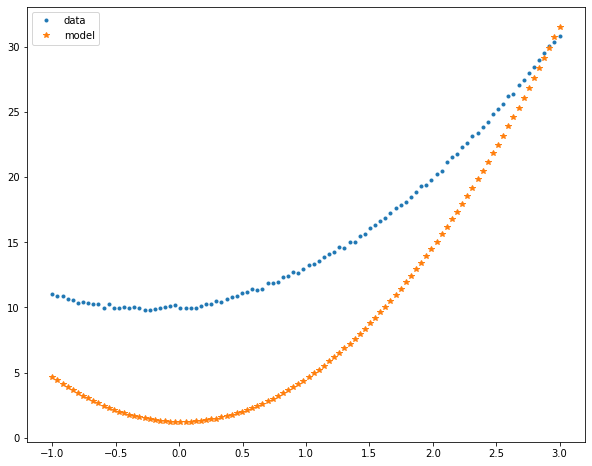

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x, y, ".", label="data")
with torch.no_grad():
    ax.plot(x, pm(torch.from_numpy(x).clone()), "*", label="model")
ax.legend()
plt.show()

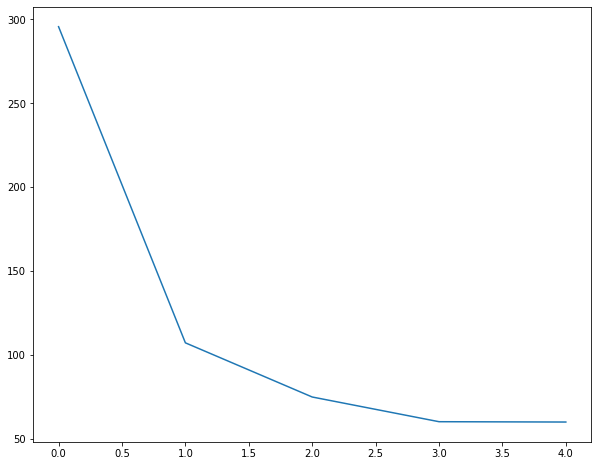

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(range(len(losses)), losses, "-", label="losses")
plt.show()

Creating a `DataBunch` version 2 via `basic_data.DataBunch.create`

In [ ]:
xy_db = basic_data.DataBunch.create(train_ds=xy_train_ds, valid_ds=xy_valid_ds, bs=bs)

In [122]:
n = len(x)
n_train = int(.7*n)
ix_train = np.random.choice(np.arange(n), replace=False, size=n_train)
ix_valid = np.setdiff1d(np.arange(n), ix_train)
print(ix_train.shape, ix_valid.shape)

df_train = pd.DataFrame({"x": x[ix_train], "y": y[ix_train]})
df_train["valid"] = False
df_valid = pd.DataFrame({"x": x[ix_valid], "y": y[ix_valid]})
df_valid["valid"] = True
df = pd.concat((df_train, df_valid), ignore_index=True)
df.head()

(70,) (30,)


,x,y,valid
0,1.343434,14.913624,False
1,0.898990,12.412504,False
2,2.717172,27.475066,False
3,-0.676768,10.253358,False
4,1.989899,20.181437,False


Note that if you use the following method the first component returned by `one_batch()` will be a list of two tensors, where the first seems, oddly enough, to have no real purpose. This won't cause an error for the model (`PolyModel`) because it is taken into account there.

In [139]:
def split_fun(x):
    return df["set"][x] == "valid"

def label_fun(x):
    print(x)
    return df["y"][x]

src = (TabularList.from_df(df=df, cont_names=["x"], procs=[Normalize])
      .split_from_df(col="valid")
      .label_from_df(cols="y"))

xy_db = src.databunch(bs=bs)

In [143]:
xy_db.one_batch() # cpu=False

(tensor([ 0.7374,  2.1515, -0.6768,  2.7172,  2.6364, -0.9596,  1.5859,  2.4747,
          0.4545, -1.0000], dtype=torch.float64),
 tensor([11.7516, 21.5481, 10.2534, 27.4751, 26.7277, 10.8067, 16.4968, 24.6748,
         10.7876, 10.9887], dtype=torch.float64))

## Setting up a polynomial model & loss

In [136]:
class PolyModel(torch.nn.Module):
    
    def __init__(self, deg: int = 1):
        super().__init__()
        self.deg = deg
        self.w = torch.nn.Parameter(torch.randn(deg))
        
    def forward(self, x):
        if isinstance(x, list):
            x = x[1]
        n = len(x)
        X = torch.empty(n, self.deg)
        #print("X", X)
        for i in range(self.deg):
            X[:,i] = x ** (self.deg-i-1)
        #print("\nX", X)
        return X @ self.w
        

In [15]:
def MSELoss(pred, truth):
    return ((pred-truth)**2).mean()

In [144]:
pm = PolyModel(deg=3)
pm(torch.randn(5))
pm.w

Parameter containing:
tensor([ 0.2001,  0.0199, -2.1910], requires_grad=True)

In [145]:
_y, _x = xy_db.one_batch()
_y_pred = pm(_x)
_y_pred

tensor([190.5820,  20.1090,  91.1555,  19.0513, 149.4184,  23.7011,  25.6788,
         18.2574,  22.1919,  18.4397], grad_fn=<MvBackward>)

## Optimization

**Implementing a bunch of optimizers**

Simple gradient based

In [160]:
class SGD:
    
    lr = .01
    name = "basic SGD"
    loss = None
    
    def __init__(self, lr=.01):
        self.lr = lr
    
    def update(self):
        _x, _y = xy_db.one_batch()
        _y_pred = pm(_x)
        loss = MSELoss(_y_pred, _y)
        loss.backward()

        with torch.no_grad():
            pm.w.sub_(pm.w.grad * self.lr)
            pm.w.grad.zero_()

        self.loss = loss.clone().detach().numpy()
        

With "momentum"

In [164]:
class SGD_mom:
    velo = torch.normal(mean=0, std=.001, size=pm.w.size()).to(device)
    momentum = .9
    lr = .01
    name = "SGD + momentum"
    loss = None
    
    def __init__(self, momentum=.9, lr=.01):
        self.momentum = momentum
        self.lr = lr

    def update(self):
        _x, _y = xy_db.one_batch()
        _y_pred = pm(_x)
        loss = MSELoss(_y_pred, _y)
        loss.backward()

        with torch.no_grad():
            self.velo.mul_(self.momentum)
            self.velo.add_(self.lr * pm.w.grad)

            pm.w.sub_(self.velo)
            pm.w.grad.zero_()

        self.loss = loss.clone().detach().numpy()
        

With "momentum" and "weight decay"

In [168]:
class SGD_mom_decay:
    velo = torch.normal(mean=0, std=.001, size=pm.w.size()).to(device)
    momentum = .9
    lr = .01
    wd = .1
    name = "SGD + momentum + weight decay"
    loss = None
    
    def __init__(self, momentum=.9, lr=.01, wd=.1):
        self.momentum = momentum
        self.lr = lr
        self.wd = wd

    def update(self):
        _x, _y = xy_db.one_batch()
        _y_pred = pm(_x)
        loss = MSELoss(_y_pred, _y)
        loss.backward()

        with torch.no_grad():
            self.velo.mul_(self.momentum)
            self.velo.add_(self.lr * pm.w.grad)

            pm.w.sub_(self.velo + self.wd*pm.w)
            pm.w.grad.zero_()

        self.loss = loss.clone().detach().numpy()
        

RMSProp: [coursera course](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf), [paper](http://arxiv.org/abs/1308.0850), a [blog post](https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a)

In [177]:
class RMSProp:
    velo = torch.normal(mean=0, std=.01, size=pm.w.size()).to(device)
    momentum = .9
    wd = .1
    beta = .9
    lr = .01
    mag = torch.tensor(1.).to(device)
    name = "RMSProp"
    
    def __init__(self, momentum=.9, lr=.01, wd=.1, beta=.9):
        self.momentum = momentum
        self.lr = lr
        self.wd = wd
        self.beta = beta
    
    def update(self):
        _x, _y = xy_db.one_batch()
        _y_pred = pm(_x)
        loss = MSELoss(_y_pred, _y)
        loss.backward()

        with torch.no_grad():
            self.mag.mul_(self.beta)
            self.mag.add_((1.-self.beta) * (pm.w @ pm.w))

            self.velo.mul_(self.momentum)
            self.velo.add_(self.lr/torch.sqrt(self.mag) * pm.w.grad)

            pm.w.sub_(self.velo + self.wd*pm.w)
            pm.w.grad.zero_()
        
        self.loss = loss.clone().detach().numpy()
        

Adam: [arXiv](https://arxiv.org/abs/1412.6980)

In [184]:
class Adam:
    
    moment1 = torch.zeros_like(pm.w, requires_grad=False)
    moment2 = torch.zeros_like(pm.w, requires_grad=False)
    betas = torch.tensor([.9, .999], requires_grad=False)
    eps = torch.tensor(1e-8, requires_grad=False)
    lr = .01
    name = "Adam"
    loss = None
    
    def __init__(self, lr: float = .01, betas: list = [.9, .999], eps: float =1e-8):
        self.betas = torch.tensor(betas, requires_grad=False)
        self.eps = eps
        self.lr = lr
    
    def update(self):
        _x, _y = xy_db.one_batch()
        _y_pred = pm(_x)
        loss = MSELoss(_y_pred, _y)
        loss.backward()

        with torch.no_grad():

            self.moment1.mul_(self.betas[0])
            self.moment1.add_((1.-self.betas[0]) * pm.w.grad)
            moment1_hat = self.moment1.div(1.-self.betas[0]**(epoch+1))

            self.moment2.mul_(self.betas[1])
            self.moment2.add_((1.-self.betas[1]) * (pm.w.grad * pm.w.grad))
            moment2_hat = self.moment2.div(1.-self.betas[1]**(epoch+1))

            pm.w.sub_(self.lr * moment1_hat / (torch.sqrt(moment2_hat) + self.eps))

        self.loss = loss.clone().detach().numpy()
    

In [273]:
moment1 = torch.zeros_like(pm.w, requires_grad=False)
# moment2 = torch.zeros(1, requires_grad=False)
moment2 = torch.zeros_like(pm.w, requires_grad=False)
betas = torch.tensor([.9, .999], requires_grad=False)
eps = torch.tensor(1e-8, requires_grad=False)

In [274]:
print(moment1, moment2, betas)

tensor([0., 0., 0.]) tensor([0., 0., 0.]) tensor([0.9000, 0.9990])


In [275]:
def update():
    _x, _y = xy_db.one_batch()
    _y_pred = pm(_x)
    loss = MSELoss(_y_pred, _y)
    loss.backward()

    with torch.no_grad():
        
        moment1.mul_(betas[0])
        moment1.add_((1.-betas[0]) * pm.w.grad)
        moment1_hat = moment1.div(1.-betas[0]**(epoch+1))
        
        moment2.mul_(betas[1])
        moment2.add_((1.-betas[1]) * (pm.w.grad * pm.w.grad))
        moment2_hat = moment2.div(1.-betas[1]**(epoch+1))
        
        pm.w.sub_(lr * moment1_hat / (torch.sqrt(moment2_hat) + eps))
    
    losses.append(loss.clone().detach().numpy())
    update_method.append("Adam")

Covariance Matrix Adaption Evolution Strategy (CMA-ES): [tutorial](https://arxiv.org/abs/1604.00772), [wiki](https://en.wikipedia.org/wiki/CMA-ES)
You may also want to check out [this](https://eli.thegreenplace.net/2011/05/15/understanding-unboundlocalerror-in-python) for variable scoping.

In [218]:
class CMA_ES:
    
    _lambda = 9 # number of agents
    mu = 4 # number of children which survive the culling
    N = pm.w.size()[0] # number of parameters

    m = pm.w.clone().detach() # position of the normal distribution
    sigma = .3 # coordinate wise standard deviation (step size)
    weights = None   # recombination weights
    mueff = None

    # Strategy parameter setting: Adaptation
    cc = None # time constant for cumulation for C
    cs = None # t-const for cumulation for sigma control
    c1 = None # learning rate for rank-one update of C
    cmu = None
    damps = None # damping for sigma, usually close to 1
    
    # Initialize dynamic (internal) strategy parameters and constants
    pc = torch.zeros(1, N).detach() # evolution paths for C and sigma
    ps = torch.zeros(1, N).detach() # evolution paths for C and sigma
    

    C = torch.eye(n=N, dtype=torch.float).detach()
    B = torch.eye(N, N).detach() # B defines the coordinate system
    D = torch.ones(N).detach() # diagonal D defines the scaling
    invsqrtC = B @ torch.diag(1 / D) @ B.transpose(0, 1)
    
    eigeneval = 0 # track update of B and D
    chiN = N**.5 * (1. - 1./(4.*N) + 1./(21.*N**2))
    
    name = "CMA-ES"
    
    def __init__(self, _lambda: int = 9, mu: int = 4, sigma: float = .3):
        self._lambda = _lambda
        self.mu = mu
        self.sigma = sigma
        
        with torch.no_grad():
            #self.agents = torch.ones((_lambda, self.N)).detach()
            self.weights = torch.ones(mu).detach()/float(mu)
            self.mueff = self.weights.sum()**2 / (self.weights @ self.weights).sum()

            self.cc = (4. + self.mueff / self.N) / (self.N + 4 + 2 * self.mueff / self.N) # time constant for cumulation for C
            self.cs = (self.mueff + 2) / (self.N + self.mueff + 5) # t-const for cumulation for sigma control
            self.c1 = 2 / ((self.N+1.3)**2 + self.mueff) # learning rate for rank-one update of C
            self.cmu = min([1 - self.c1, 2 * (self.mueff - 2 + 1 / self.mueff) / ((self.N + 2)**2 + self.mueff)])
            self.damps = 1 + 2 * max(0, torch.sqrt((self.mueff - 1)/(self.N + 1)) - 1) + self.cs # damping for sigma, usually close to 1

    def update(self):

        _x, _y = xy_db.one_batch()
        _y_pred = pm(_x)
        loss = MSELoss(_y_pred, _y)

        with torch.no_grad():


            agents = (torch.distributions.multivariate_normal.MultivariateNormal(self.m, covariance_matrix = self.C)
                      .sample(sample_shape=torch.Size([self._lambda])))

            for _i in range(self._lambda):
                pm.w = torch.nn.Parameter(agents[_i])
                _y_pred = pm(_x)
                fitnesses[_i] = MSELoss(_y_pred, _y)

            idx = torch.argsort(fitnesses)[:self.mu] # assumes that the best individuals are those with the lowest fitness values

            m_new = agents[idx].mean(dim=0)

            # Update evolution paths     
            self.ps = (1-self.cs) * self.ps + torch.sqrt(self.cs * (2-self.cs)*self.mueff) \
                      * self.invsqrtC @ (m_new - self.m)/self.sigma

            hsig = 2./(self.N+1.)
            if not (torch.norm(self.ps) / torch.sqrt(1-(1-self.cs)**(2*(epoch+1)/self._lambda))/self.chiN < 1.4):
                hsig += 1.

            self.pc = (1-self.cc) * self.pc + hsig * torch.sqrt(self.cc * (2-self.cc)*self.mueff) \
                      * (m_new - self.m)/self.sigma

            # Adapt covariance matrix C
            artmp = 1/self.sigma * (agents[idx] - self.m)

            self.C = (1. - self.c1 - self.cmu) * self.C \
                      + self.c1 * ( \
                              torch.einsum("i,j->ij", self.pc[0], self.pc[0]) \
                              + (1-hsig) * self.cc*(2-self.cc) * self.C
                             ) \
                      + self.cmu * artmp.transpose(0, 1) @ torch.diag(self.weights) @ artmp

            self.sigma = self.sigma * torch.exp((self.cs/self.damps)*(torch.norm(self.ps)/self.chiN - 1.))

            if epoch - self.eigeneval > self._lambda/(self.c1+self.cmu)/self.N/10.:

                self.eigeneval = epoch
                self.C = self.C.triu() + self.C.triu(1).transpose(0, 1)
                (D, B) = self.C.eig(eigenvectors=True)
                self.invsqrtC = B @ torch.diag(1./D[:,0]) @ B.transpose(0, 1)

            pm.w = torch.nn.Parameter(m_new)
            self.m = m_new.clone()
            
            
        
        self.loss = loss.clone().detach().numpy()


With one of pytorch's optimizers

In [222]:
# opt = torch.optim.SGD(pm.parameters(), lr=.01, momentum=.9)

class PyTorch:
    
    opt = None
    loss = None
    name = "pytorch optimizer"
    
    def __init__(self, opt: torch.optim.Optimizer):
        self.opt = opt
        
    def update(self):
        self.opt.zero_grad()
        _x, _y = xy_db.one_batch()
        _y_pred = pm(_x)
        loss = MSELoss(_y_pred, _y)
        loss.backward()

        self.opt.step()

        self.loss = loss.clone().detach().numpy()


**Running an optimizer for a while**

In [253]:
# initialize random weights
pm = PolyModel(deg=3)
pm(torch.randn(5))

tensor([-1.2038,  1.7112,  0.0200,  0.0604,  3.5957], grad_fn=<MvBackward>)

In [179]:
lr = .05 # for some reason the adam implementation requires a much larger (.9+) "learning rate" than the other algs
n_epochs = 50

In [248]:
losses = []
update_method = []

In [129]:
pm.w

Parameter containing:
tensor([-0.1029, -0.8630,  1.1719], requires_grad=True)

In [225]:
# _optimizer = SGD(lr=.01)
# _optimizer = SGD_mom(lr=.01, momentum=.9)
# _optimizer = SGD_mom_decay(lr=.01, momentum=.9, wd=.1)
# _optimizer = RMSProp(lr=.01, momentum=.9, wd=.1, beta=.9)
# _optimizer = Adam(lr=.01, betas=[.9, .999], eps=1e-8)
# _optimizer = CMA_ES(_lambda=9, mu=4, sigma=.3)
_optimizer = PyTorch(opt=torch.optim.SGD(pm.parameters(), lr=.01, momentum=.9))

for epoch in range(n_epochs): # range(n_epochs):
    #update()
    _optimizer.update()
    update_method.append(_optimizer.name)
    losses.append(_optimizer.loss)

In [93]:
pm.w

Parameter containing:
tensor([2.0940, 1.1121, 9.3637], requires_grad=True)

**Running a bunch of different optimizers**

Essentially the same as above but directly running a series of optimizers.

In [254]:
w0 = pm.w.clone()

In [261]:
optimizers = [
#     SGD(lr=.01),
#     SGD_mom(lr=.01, momentum=.9),
#     SGD_mom_decay(lr=.01, momentum=.9, wd=.1),
#     RMSProp(lr=.01, momentum=.9, wd=.1, beta=.9),
#     Adam(lr=.01, betas=[.9, .999], eps=1e-8),
#     CMA_ES(_lambda=9, mu=4, sigma=.3),
    PyTorch(opt=torch.optim.SGD(pm.parameters(), lr=.1, momentum=.9))
]

for _optimizer in optimizers:
    print("\n", _optimizer)
    pm.w = torch.nn.Parameter(w0.clone())
    for epoch in range(n_epochs):
        _optimizer.update()
        update_method.append(_optimizer.name)
        losses.append(_optimizer.loss)
    print(pm.w)


Parameter containing:
tensor([-0.7629,  2.3541,  1.8252], requires_grad=True)


**How well is the data fitted for a single weights vector?**

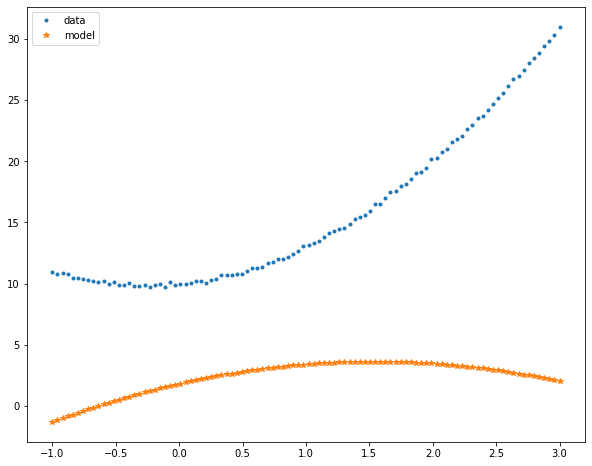

In [262]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x, y, ".", label="data")
with torch.no_grad():
    ax.plot(x, pm(torch.from_numpy(x).clone()), "*", label="model")
ax.legend()
plt.show()

**Loss plots over multiple optimization methods**

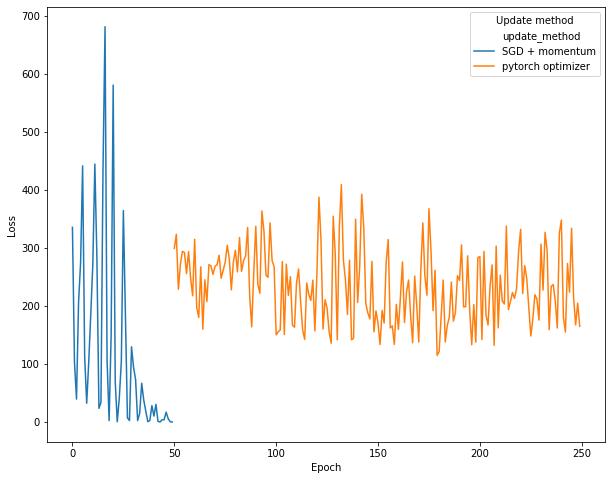

In [263]:
df_plot = pd.DataFrame({"update_method": update_method, "losses": np.array(losses), "epoch": np.arange(len(losses))})

fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(data=df_plot, x="epoch", y="losses", ax=ax , hue="update_method")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(title="Update method")
plt.show()